In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
from itertools import chain
import os
import cv2
import random
import zipfile
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns   #←これを追加
import timm    #←これを追加
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
class CFG:
  # No. of epochs for training the model
  # Training settings
  batch_size = 25
  epochs = 20
  lr = 3e-5
  gamma = 0.7
  seed = 42                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [3]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


In [4]:
from pathlib import Path
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [5]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath).convert(mode="RGB")

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [6]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

In [7]:
count1=0
count2=0
count3=0
for i in train_dir:
    if "A" in i[30:]:
        count1+=1
    if "B" in i[30:]:
        count2+=1
    if "C" in i[30:]:
        count3+=1
count1,count2,count3

(400, 400, 400)

GridMask

In [7]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMix

In [8]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

In [9]:
import albumentations
import albumentations.pytorch

In [10]:
train_transformer= albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=3, mode=0, rotate=15),
        GridMask(num_grid=3, mode=2, rotate=15),
    ], p=0.7),
    RandomAugMix(severity=4, width=3, alpha=1.0, p=0.7)
])
test_transformer=train_transformer= transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean,std)

])

In [11]:
train=Dataset(train_dir,train_transformer)
test=Dataset(test_dir,test_transformer)

In [12]:
# train_loader = DataLoader(dataset = train, batch_size=CFG.batch_size, shuffle=True ,num_workers=16,pin_memory=True)
# test_loader = DataLoader(dataset = test, batch_size=CFG.batch_size, shuffle=True,num_workers=16,pin_memory=True)

In [13]:
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [14]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=3)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [15]:
# model = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=3,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

In [16]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)

In [17]:
import time
from tqdm import tqdm
import time
import copy

In [18]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [19]:
classes=['A','B','C']

In [20]:
from cmath import inf
def train_model(model, criterion, optimizer, scheduler, train_loader,val_loader,train_dataset,valid_dataset,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = inf
    dataloaders = {
        "train":train_loader,
        "val": val_loader
    }
    dataset_sizes = {
        "train":len(train_dataset),
        "val": len(valid_dataset)
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda().float(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [22]:
import gc

In [23]:
train_directory=np.array(train_dir)

In [24]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        print(len(train_dir))
        print(len(valid_dir))

960
240
960
240
960
240
960
240
960
240


In [25]:
original_wts=copy.deepcopy(model.state_dict())

In [26]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        
        train_dataset = Dataset(train_dir,train_transformer)
        train_loader = DataLoader(train_dataset, CFG.batch_size, shuffle=True,num_workers=8)
        valid_dataset = Dataset(valid_dir,test_transformer)
        val_loader = DataLoader(valid_dataset, CFG.batch_size, shuffle=False,num_workers=8)
        model.load_state_dict(original_wts)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)
        model_ft = train_model(model, criterion, optimizer, scheduler,train_loader,val_loader,
                        train_dataset,valid_dataset,num_epochs=CFG.epochs) 
        dir_path='./weights/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(model_ft.state_dict(), f'./weights/model_5e_{fold_idx}.pth')
        print(f'{fold_idx+1}th epoch finished!')
        gc.collect()

Epoch 0/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.57it/s]


train Loss: 0.8302 Acc: 0.6042


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.7122 Acc: 0.6708
Epoch 1/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.6248 Acc: 0.7219


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.6731 Acc: 0.6667
Epoch 2/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.5008 Acc: 0.7823


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.6724 Acc: 0.6708
Epoch 3/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.3284 Acc: 0.8844


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.6725 Acc: 0.6792
Epoch 4/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.1982 Acc: 0.9479


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.7831 Acc: 0.7042
Epoch 5/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.1324 Acc: 0.9698


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7710 Acc: 0.6875
Epoch 6/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


train Loss: 0.0775 Acc: 0.9927


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8057 Acc: 0.7000
Epoch 7/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0552 Acc: 0.9958


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.8360 Acc: 0.6792
Epoch 8/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.0444 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8518 Acc: 0.6833
Epoch 9/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0387 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8635 Acc: 0.7000
Epoch 10/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


train Loss: 0.0352 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8748 Acc: 0.7000
Epoch 11/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0329 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.8796 Acc: 0.7000
Epoch 12/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0314 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8873 Acc: 0.7000
Epoch 13/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0303 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8891 Acc: 0.7000
Epoch 14/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.0296 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8912 Acc: 0.7000
Epoch 15/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.60it/s]


train Loss: 0.0291 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.8929 Acc: 0.7000
Epoch 16/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0288 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8939 Acc: 0.7000
Epoch 17/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0286 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8951 Acc: 0.7000
Epoch 18/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


train Loss: 0.0284 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.8961 Acc: 0.7000
Epoch 19/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.0282 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.8966 Acc: 0.7000
Training complete in 4m 8s
Best val loss: 0.672398
1th epoch finished!
Epoch 0/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.8245 Acc: 0.6198


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7833 Acc: 0.6333
Epoch 1/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.6027 Acc: 0.7385


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.6489 Acc: 0.7000
Epoch 2/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.4342 Acc: 0.8344


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.6750 Acc: 0.6792
Epoch 3/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.3059 Acc: 0.8958


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.7070 Acc: 0.6958
Epoch 4/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.1845 Acc: 0.9531


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.7876 Acc: 0.6750
Epoch 5/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.1050 Acc: 0.9802


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.7840 Acc: 0.6875
Epoch 6/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0700 Acc: 0.9938


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8498 Acc: 0.6958
Epoch 7/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0543 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.8591 Acc: 0.6833
Epoch 8/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0436 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.8713 Acc: 0.6875
Epoch 9/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.0386 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.8897 Acc: 0.6833
Epoch 10/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0355 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8957 Acc: 0.6833
Epoch 11/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0334 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.9015 Acc: 0.6833
Epoch 12/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0320 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.9085 Acc: 0.6833
Epoch 13/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0310 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.9058 Acc: 0.6833
Epoch 14/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0303 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.9098 Acc: 0.6833
Epoch 15/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.0299 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.9084 Acc: 0.6833
Epoch 16/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0295 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


val Loss: 0.9112 Acc: 0.6833
Epoch 17/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0292 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.9119 Acc: 0.6833
Epoch 18/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0291 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.9131 Acc: 0.6833
Epoch 19/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.0289 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.9136 Acc: 0.6833
Training complete in 4m 9s
Best val loss: 0.648905
2th epoch finished!
Epoch 0/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.8432 Acc: 0.6042


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7434 Acc: 0.6625
Epoch 1/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.6100 Acc: 0.7125


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.7378 Acc: 0.6500
Epoch 2/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.4654 Acc: 0.8031


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7620 Acc: 0.7083
Epoch 3/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.3488 Acc: 0.8562


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.7443 Acc: 0.6833
Epoch 4/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.43it/s]


train Loss: 0.2014 Acc: 0.9396


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8497 Acc: 0.6792
Epoch 5/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.1171 Acc: 0.9760


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.9335 Acc: 0.6917
Epoch 6/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0740 Acc: 0.9875


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.9805 Acc: 0.6833
Epoch 7/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0518 Acc: 0.9948


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.0159 Acc: 0.6792
Epoch 8/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0406 Acc: 0.9958


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.0542 Acc: 0.6875
Epoch 9/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0339 Acc: 0.9958


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


val Loss: 1.0779 Acc: 0.6958
Epoch 10/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0303 Acc: 0.9979


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0961 Acc: 0.6875
Epoch 11/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.0279 Acc: 0.9979


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.1093 Acc: 0.6833
Epoch 12/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.0264 Acc: 0.9979


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.1134 Acc: 0.6875
Epoch 13/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0253 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 1.1187 Acc: 0.6875
Epoch 14/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0247 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 1.1234 Acc: 0.6833
Epoch 15/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


train Loss: 0.0242 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 1.1261 Acc: 0.6875
Epoch 16/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0238 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 1.1293 Acc: 0.6875
Epoch 17/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0236 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.1301 Acc: 0.6833
Epoch 18/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0234 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 1.1309 Acc: 0.6833
Epoch 19/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0233 Acc: 0.9990


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 1.1316 Acc: 0.6833
Training complete in 4m 9s
Best val loss: 0.737850
3th epoch finished!
Epoch 0/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.8418 Acc: 0.5917


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7323 Acc: 0.6208
Epoch 1/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.5734 Acc: 0.7604


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.6596 Acc: 0.7208
Epoch 2/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.4344 Acc: 0.8250


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.6756 Acc: 0.7167
Epoch 3/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.2835 Acc: 0.9104


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.7909 Acc: 0.6292
Epoch 4/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.1700 Acc: 0.9604


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.7388 Acc: 0.7167
Epoch 5/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


train Loss: 0.1000 Acc: 0.9896


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8252 Acc: 0.6667
Epoch 6/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0676 Acc: 0.9948


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.8350 Acc: 0.6875
Epoch 7/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.0517 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.8654 Acc: 0.6708
Epoch 8/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0434 Acc: 0.9979


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8793 Acc: 0.6792
Epoch 9/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.0384 Acc: 0.9979


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.8837 Acc: 0.6792
Epoch 10/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0351 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.8929 Acc: 0.6792
Epoch 11/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0330 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.9029 Acc: 0.6833
Epoch 12/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.50it/s]


train Loss: 0.0317 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.9069 Acc: 0.6833
Epoch 13/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


train Loss: 0.0308 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.9107 Acc: 0.6833
Epoch 14/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


train Loss: 0.0300 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.9130 Acc: 0.6833
Epoch 15/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.55it/s]


train Loss: 0.0295 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


val Loss: 0.9150 Acc: 0.6833
Epoch 16/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0292 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.9155 Acc: 0.6833
Epoch 17/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0290 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


val Loss: 0.9166 Acc: 0.6833
Epoch 18/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0288 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.9171 Acc: 0.6833
Epoch 19/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0287 Acc: 1.0000


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


val Loss: 0.9182 Acc: 0.6833
Training complete in 4m 8s
Best val loss: 0.659555
4th epoch finished!
Epoch 0/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.8299 Acc: 0.6042


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 0.7207 Acc: 0.6292
Epoch 1/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.6121 Acc: 0.7219


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.8675 Acc: 0.5958
Epoch 2/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.4435 Acc: 0.8260


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


val Loss: 0.9077 Acc: 0.6417
Epoch 3/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.3181 Acc: 0.8771


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 0.8640 Acc: 0.6458
Epoch 4/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.1990 Acc: 0.9500


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 0.8647 Acc: 0.6458
Epoch 5/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.1216 Acc: 0.9729


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


val Loss: 0.9507 Acc: 0.6542
Epoch 6/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0834 Acc: 0.9865


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


val Loss: 0.9603 Acc: 0.6750
Epoch 7/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.0634 Acc: 0.9927


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 1.0183 Acc: 0.6625
Epoch 8/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0512 Acc: 0.9948


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0400 Acc: 0.6708
Epoch 9/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0448 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0486 Acc: 0.6708
Epoch 10/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0409 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 1.0645 Acc: 0.6708
Epoch 11/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0382 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 1.0683 Acc: 0.6708
Epoch 12/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.53it/s]


train Loss: 0.0368 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.0781 Acc: 0.6750
Epoch 13/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0353 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.0825 Acc: 0.6792
Epoch 14/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0345 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0854 Acc: 0.6792
Epoch 15/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.52it/s]


train Loss: 0.0339 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


val Loss: 1.0889 Acc: 0.6792
Epoch 16/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.51it/s]


train Loss: 0.0335 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


val Loss: 1.0890 Acc: 0.6792
Epoch 17/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.55it/s]


train Loss: 0.0332 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0901 Acc: 0.6792
Epoch 18/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.54it/s]


train Loss: 0.0330 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0911 Acc: 0.6792
Epoch 19/19
----------


100%|██████████| 39/39 [00:08<00:00,  4.56it/s]


train Loss: 0.0328 Acc: 0.9969


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


val Loss: 1.0918 Acc: 0.6792
Training complete in 4m 6s
Best val loss: 0.720692
5th epoch finished!


In [27]:
train_acc_list=torch.tensor(training_history['accuracy'])
train_loss_list=torch.tensor(training_history['loss'])
val_acc_list=torch.tensor(validation_history['accuracy'])
val_loss_list=torch.tensor(validation_history['loss'])

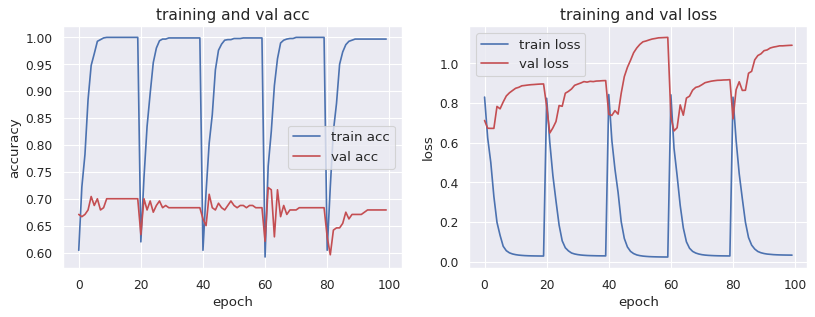

In [28]:
import seaborn as sns
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(CFG.epochs*5):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i]
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs =CFG.epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs*5), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs*5), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs*5), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs*5), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()